# Object detection using SSD

For 4x4 (16) anchor boxes layout and 1 head output for SSD

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

In [3]:
from fastai.conv_learner import *
from fastai.dataset import *

import json, pdb
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
import pandas as pd

# Define functions

In [4]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

    
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    draw_im(im, im_a)

In [5]:
# function and library for plotting corloful bounding boxes
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    bb = [bb_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>0) and (pr is None or pr > thresh)):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c==len(id2cat) else id2cat[c])
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])

In [6]:
class ConcatLblDataset(Dataset): 
    # create new dataset with original X and new y which is a tuple: (y_bbox,y_label)
    # inherit torch Dataset
    
    def __init__(self, ds, y2): 
        self.ds,self.y2 = ds,y2
        self.sz = ds.sz
    #self.ds contains np array X and y of bbox dataset
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i])) # (X,(y_bbox,y_label))

In [7]:
class StdConv(nn.Module):
    '''
    A standard conv->relu->batch_norm-> dropout block
    '''
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))
        
class OutConv(nn.Module):
    '''
    '''
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        
        # both of conv2d below are stride 1
        # oconv1 predict labels: 4x4x256 to 4x4x(# labels + 1 for background)
        self.oconv1 = nn.Conv2d(nin, (len(id2cat)+1)*k, 3, padding=1)
        
        # oconv2 predict bbox coord: 4x4x256 to 4x4x4
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1)
        
        # zero reset and add some constant (bias) to 
        #   label-predictoin conv2d bias. TODO: why?
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        # (bs,256,4,4) to [(bs,16,21),(bs,16,4)]
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]
        
def flatten_conv(x,k): 
    '''
    x.size is either (bs,# labels,4,4) or (bs,# of coord,4,4)
    Transform x into (bs,4,4,# labels/coord) then (bs,16,# labels/coord)
    '''
    
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        
        # start with stride 1: not change height x width, only # channels
        # ''mini neural net' using conv2d
        self.sconv0 = StdConv(512,256, stride=1)
        
#         self.sconv1 = StdConv(256,256)
        self.sconv2 = StdConv(256,256) # stride 2 -> turn 7x7x256 to 4x4x256
        self.out = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x) # (bs,512,7,7) to (bs,512,7,7)
#         x = self.sconv1(x)
        x = self.sconv2(x) # (bs,512,7,7) to (bs,256,4,4) b/c stride 2
        return self.out(x) # (bs,256,4,4) to [(bs,16,21),(bs,16,4)]

In [8]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    '''
    Intuition:
    Since pred is (16,20labels+1bg) and ground-truth is (16,) including bg
    Each anchor box (out of 16) can only have 1 label
    Why do we have to use BCE loss? 
    Softmax makes it harder for model to classify background since model has to
        classify this grid cell that does not have any of the main 20 objs with IOU >.5
    
    Using BCE we can identify background easier.
    If 20 labels after one-hot is all 0 -> background
    
    So: we will one-hot target to size (16,21), ignore bg, 
        apply softmax for each of 16 a-box and calculate CE (log loss)
    
    '''
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        # don't accept batch? 1 input at a time
        t = one_hot_embedding(targ, self.num_classes+1) # (16,20+1)
        t = V(t[:,:-1].contiguous())#.cpu() # ignore 21st labels, bg
        x = pred[:,:-1] # same for prediction, ignore its 21st labels
        # TODO: can we just not include bg at all if we exclude it anyway when calculating l1 loss?
        w = self.get_weight(x,t) # This is to set focal loss. This is defined in multihead SSD
        
        # calculate log loss for each label and take the mean
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/self.num_classes
    
    def get_weight(self,x,t): return None

In [9]:
def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]) )

def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

def get_y(bbox,clas):
    # accept 1 input at a time
    bbox = bbox.view(-1,4)/sz #scale down to [0,1] relative to 224 (size of img)
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0] # index of non-zero entry
    return bbox[bb_keep],clas[bb_keep]

def actn_to_bb(actn, anchors):
    '''
    Convert conv2d bbox output for 1 img (16,4 coords upper left lower right) 
    to a (16,4 coord lower left upper right) matrix based on anchor box h,w and center
    
    actn: (16,4) y1x1 y2x2
    anchors: (16,4) center_x,center_y,w,h (w=h=grid_sizes)
    '''
    actn_bbs = torch.tanh(actn) # scale b/t -1 and 1
    
    # move center of anchor box around actn/2
    # each preditive bbox can be mobed by up to 50% of a grid size
    # where its default position (anchor box) is
    # TODO: ???
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print(prior_overlap)
#     pdb.set_trace()
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

def ssd_1_loss(b_c,b_bb,bbox,clas,print_it=False):
    '''
    SSD loss for 1 IMAGE
    Input: predicted classes b_c(16,21) and bbox b_bb(16,4) from oconv1 and oconv2
           actual classes clas (max,1) and actual bbox (max,4) from y data loader
    '''
    # predicted stuff process
    a_ic = actn_to_bb(b_bb, anchors) # abox-transformation predicted bbox (16,4)
    
    
    #ground-truth stuff process
    bbox,clas = get_y(bbox,clas) # bbox: (# labels,4), clas: (# labels,1)
    
    #get pos_idx: idx of abox where IOU > .4
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps,print_it)
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    
    #get gt_clas
    gt_clas = clas[gt_idx] # idx of obj for each abox (16,1)
    gt_clas[1-pos] = len(id2cat) #assign 'bg' class idx 20 to gt_clas
    #get gt_bbox
    gt_bbox = bbox[gt_idx] # idx of bbox for each abox (16,4)
    
    #calculate loss
    # for location loss (l1 loss): only calculate loss for >.4 IOU bbox
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    # BCE loss
    clas_loss  = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss

def ssd_loss(pred,targ,print_it=False):
    # Loop through each img pred and targ from batch to calculate loss
    lcs,lls = 0.,0.
    for b_c,b_bb,bbox,clas in zip(*pred,*targ): # get each of img pred and targ from batch
        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas,print_it)
        lls += loc_loss
        lcs += clas_loss
    if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
        
    # Note that you are not scaling l1 loss (lls). Turn out we don't need to...?
    return lls+lcs 

# Experiment with custom head and concat dataset

In [5]:
PATH = Path('data/pascal')
list(PATH.iterdir())

[PosixPath('data/pascal/tmp'),
 PosixPath('data/pascal/all_info.csv'),
 PosixPath('data/pascal/VOC2012'),
 PosixPath('data/pascal/pascal_val2012.json'),
 PosixPath('data/pascal/pascal_test2007.json'),
 PosixPath('data/pascal/pascal_val2007.json'),
 PosixPath('data/pascal/lrg_bbox.csv'),
 PosixPath('data/pascal/VOC2007'),
 PosixPath('data/pascal/models'),
 PosixPath('data/pascal/mult_cat.csv'),
 PosixPath('data/pascal/mult_bbox.csv'),
 PosixPath('data/pascal/VOCtrainval_11-May-2012.tar'),
 PosixPath('data/pascal/pascal_train2012.json'),
 PosixPath('data/pascal/pascal_train2007.json'),
 PosixPath('data/pascal/lrg_cat.csv'),
 PosixPath('data/pascal/VOCtrainval_06-Nov-2007.tar')]

In [6]:
JPEGS = 'VOC2007/JPEGImages'
IMG_PATH = PATH/JPEGS

In [7]:
all_df = pd.read_csv(PATH / 'all_info.csv')
mult_cat= pd.read_csv(PATH / 'mult_cat.csv')
mult_bbox= pd.read_csv(PATH / 'mult_bbox.csv') 

In [8]:
mult_cat.head()

file_name                              cat_name
0  000012.jpg                                   car
1  000017.jpg                          person horse
2  000023.jpg  bicycle bicycle person person person
3  000026.jpg                                   car
4  000032.jpg     aeroplane aeroplane person person

In [9]:
mult_cat['nlabels'] = mult_cat.cat_name.apply(lambda x: len(x.split(' ')))

In [10]:
mult_cat.nlabels.max()

19

In [11]:
mult_bbox.head()

file_name                                               bbox
0  000012.jpg                                     96 155 269 350
1  000017.jpg                       61 184 198 278 77 89 335 402
2  000023.jpg  229 8 499 244 219 229 499 333 0 1 368 116 1 2 ...
3  000026.jpg                                     124 89 211 336
4  000032.jpg  77 103 182 374 87 132 122 196 179 194 228 212 ...

In [12]:
all_df.shape

(7844, 11)

In [13]:
cats=all_df[['category_id','cat_name']].drop_duplicates().values

In [14]:
id2cat = {i[0]-1:i[1] for i in cats}
cat2id = {i[1]:i[0]-1 for i in cats}

In [15]:
mcs=np.array([np.array([cat2id[j] for j in i.split(' ')]) for i in mult_cat.cat_name.values ])
mcs

array([array([6]), array([14, 12]), array([ 1,  1, 14, 14, 14]), ..., array([17,  8, 14, 14, 14]),
       array([6]), array([11])], dtype=object)

In [16]:
val_idxs = get_cv_idxs(mult_bbox.shape[0])
((val_mcs,trn_mcs),) = split_by_idx(val_idxs, mcs)

In [17]:
val_mcs[:5]

array([array([ 1, 14, 14]), array([11, 17]), array([2]), array([14]), array([14, 14, 14, 14, 14,  4,  4])],
      dtype=object)

In [18]:
f_model=resnet34
sz=224
bs=16

In [19]:
MBB_CSV = PATH / 'mult_bbox.csv'
aug_tfms = [RandomRotate(10, tfm_y=TfmType.COORD),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD),
            RandomFlip(tfm_y=TfmType.COORD)]
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=aug_tfms)
md = ImageClassifierData.from_csv(PATH, JPEGS, MBB_CSV, tfms=tfms, continuous=True, num_workers=4)


In [22]:
class ConcatLblDataset(Dataset): 
    # create new dataset with original X and new y which is a tuple: (y_bbox,y_label)
    # inherit torch Dataset
    
    def __init__(self, ds, y2): 
        self.ds,self.y2 = ds,y2
        self.sz = ds.sz
    #self.ds contains np array X and y of bbox dataset
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i])) # (X,(y_bbox,y_label))

In [23]:
md.trn_ds[1][0].shape
md.trn_ds[1][1].shape

(3, 224, 224)

(8,)

In [24]:
# md.trn_ds (created from ImageClassifierData.from_csv) and trn_mcs (from get_cv_idxs) have same indices
# as .from_csv also used get_cv_idxs func
trn_ds2 = ConcatLblDataset(md.trn_ds, trn_mcs)
val_ds2 = ConcatLblDataset(md.val_ds, val_mcs)
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

In [25]:
#get data directly from model's ds
# X of img with idx 1 is md.trn_ds[1][0]
# y is md.trn_ds[1][1]
md.trn_ds[1][0].shape
md.trn_ds[1][1][0].shape
md.trn_ds[1][1][0]
md.trn_ds[1][1][1].shape
md.trn_ds[1][1][1]

(3, 224, 224)

(8,)

array([ 34.,  89., 121., 137.,  36.,  32., 215., 190.], dtype=float32)

(2,)

array([14, 12])

When using data loader (to get batches) for multiple classes + multiple bbox dataset,<br>
y width (axis 1) size is automatically resize to largest # of labels assigned to that batch

In [26]:
# get data from model's data loader
x,y=to_np(next(iter(md.trn_dl)))
x=md.trn_ds.ds.denorm(x)
x.shape

(64, 224, 224, 3)

In [27]:
y[0].shape # largest # of bbox assigned to an img * 4 (4 coords).
y[1].shape # largest # of labels assigned to an img for this batch

(64, 60)

(64, 15)

In [28]:
# y_bbox and y_label of 2nd picture from md.trn_dl batch
y[0][1]
y[1][1]

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,  65.,  54., 181., 184.], dtype=float32)

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 14])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


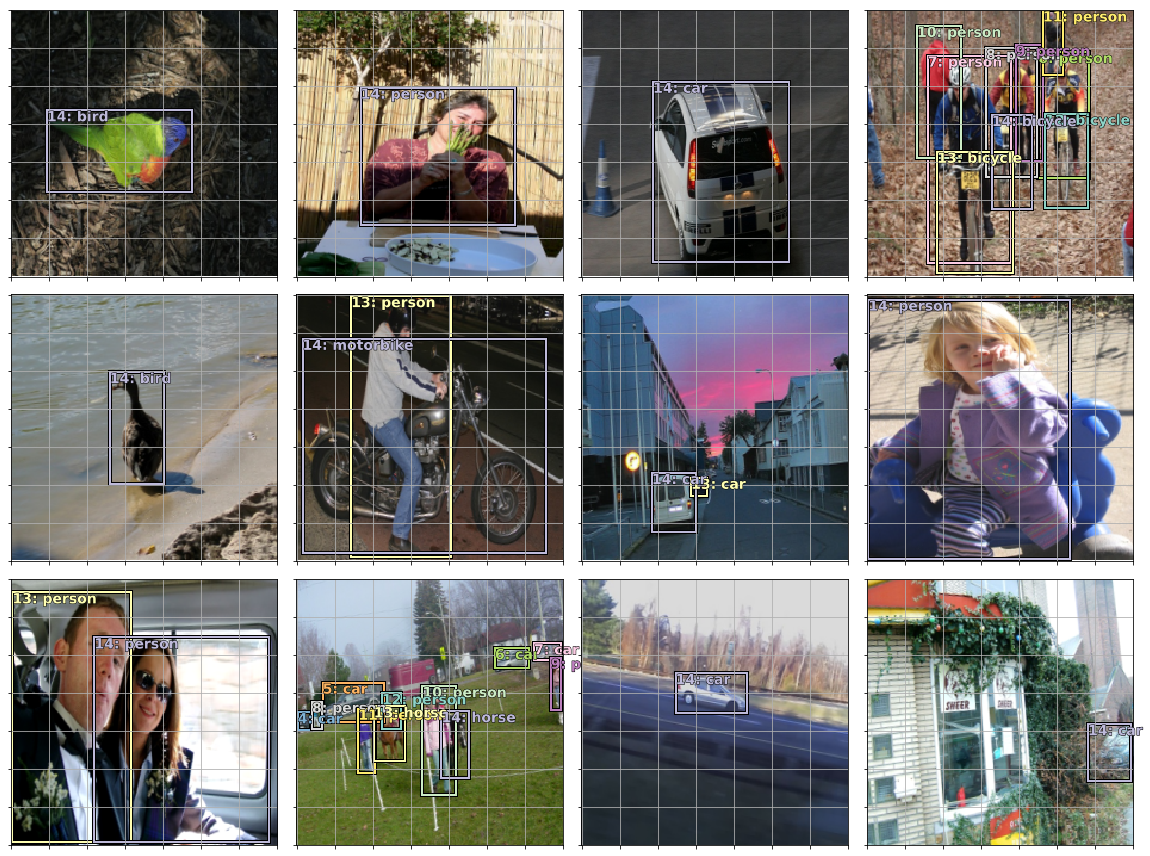

In [29]:

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for i,ax in enumerate(axes.flat):
    show_ground_truth(ax, x[i], y[0][i], y[1][i])
plt.tight_layout()

# Simple model: predict obj for each cell of a 4x4 grid

In [30]:
k=1
n_clas = len(id2cat)+1; n_clas
n_act = k*(4+n_clas); n_act


21

25

# Custom head for SSD

Reminder: 
- Last layer from the resnetblock is
```
(2): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
     (relu): ReLU(inplace)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
   )
 )]
```

- Custom head (attach to above layer) for 1 bbox and 1 label is:
```
head_reg4 = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    # No need for a batchnorm here since last resnetblock already have it
    nn.Dropout(0.5),
    nn.Linear(25088,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4+len(cats)), # predict 4 bbox coords + 20 cats at the same time
    # Note that there is no softmax or sigmoid activation applied to the last layer
)
```

Last layer from the resnetblock is

In [31]:
class StdConv(nn.Module):
    '''
    A standard conv->relu->batch_norm-> dropout block
    '''
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))
        


class OutConv(nn.Module):
    '''
    '''
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        
        # both of conv2d below are stride 1
        # oconv1 predict labels: 4x4x256 to 4x4x(# labels + 1 for background)
        self.oconv1 = nn.Conv2d(nin, (len(id2cat)+1)*k, 3, padding=1)
        
        # oconv2 predict bbox coord: 4x4x256 to 4x4x4
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1)
        
        # zero reset and add some constant (bias) to 
        #   label-predictoin conv2d bias. TODO: why?
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        # (bs,256,4,4) to [(bs,16,21),(bs,16,4)]
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]
        

def flatten_conv(x,k): 
    '''
    x.size is either (bs,# labels,4,4) or (bs,# of coord,4,4)
    Transform x into (bs,4,4,# labels/coord) then (bs,16,# labels/coord)
    '''
    
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

    
class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        
        # start with stride 1: not change height x width, only # channels
        # ''mini neural net' using conv2d
        self.sconv0 = StdConv(512,256, stride=1)
        
#         self.sconv1 = StdConv(256,256)
        self.sconv2 = StdConv(256,256) # stride 2 -> turn 7x7x256 to 4x4x256
        self.out = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x) # (bs,512,7,7) to (bs,512,7,7)
#         x = self.sconv1(x)
        x = self.sconv2(x) # (bs,512,7,7) to (bs,256,4,4) b/c stride 2
        return self.out(x) # (bs,256,4,4) to [(bs,16,21),(bs,16,4)]

In [32]:
head_reg4 = SSD_Head(k, -3.)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
# k

In [33]:
head_reg4

SSD_Head(
  (drop): Dropout(p=0.25)
  (sconv0): StdConv(
    (conv): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (drop): Dropout(p=0.1)
  )
  (sconv2): StdConv(
    (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (drop): Dropout(p=0.1)
  )
  (out): OutConv(
    (oconv1): Conv2d(256, 21, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (oconv2): Conv2d(256, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

# Custom loss function

In [34]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    '''
    Intuition:
    Since pred is (16,20labels+1bg) and ground-truth is (16,) including bg
    Each anchor box (out of 16) can only have 1 label
    Why do we have to use BCE loss? 
    Softmax makes it harder for model to classify background since model has to
        classify this grid cell that does not have any of the main 20 objs with IOU >.5
    
    Using BCE we can identify background easier.
    If 20 labels after one-hot is all 0 -> background
    
    So: we will one-hot target to size (16,21), ignore bg, 
        apply softmax for each of 16 a-box and calculate CE (log loss)
    
    '''
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        # don't accept batch? 1 input at a time
        t = one_hot_embedding(targ, self.num_classes+1) # (16,20+1)
        t = V(t[:,:-1].contiguous())#.cpu() # ignore 21st labels, bg
        x = pred[:,:-1] # same for prediction, ignore its 21st labels
        w = self.get_weight(x,t) # TODO: what?
        
        # calculate log loss for each label and take the mean
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/self.num_classes
    
    def get_weight(self,x,t): return None

loss_f = BCE_Loss(len(id2cat))



In [35]:
def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]) )

def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

In [36]:
def get_y(bbox,clas):
    # accept 1 input at a time
    bbox = bbox.view(-1,4)/sz #scale down to [0,1] relative to 224 (size of img)
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0] # index of non-zero entry
    return bbox[bb_keep],clas[bb_keep]

def actn_to_bb(actn, anchors):
    '''
    Convert conv2d bbox output for 1 img (16,4 coords upper left lower right) 
    to a (16,4 coord lower left upper right) matrix based on anchor box h,w and center
    actn: (16,4) y1x1 y2x2
    anchors: (16,4) center_x,center_y,w,h (w=h=grid_sizes)
    '''
    actn_bbs = torch.tanh(actn) # scale b/t -1 and 1
    
    # move center of anchor box around actn/2
    # each preditive bbox can be mobed by up to 50% of a grid size
    # where its default position (anchor box) is
    # TODO: ???
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print(prior_overlap)
#     pdb.set_trace()
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

def ssd_1_loss(b_c,b_bb,bbox,clas,print_it=False):
    '''
    SSD loss for 1 IMAGE
    Input: predicted classes b_c(16,21) and bbox b_bb(16,4) from oconv1 and oconv2
           actual classes clas (max,1) and actual bbox (max,4) from y data loader
    '''
    # predicted stuff process
    a_ic = actn_to_bb(b_bb, anchors) # abox-transformation predicted bbox (16,4)
    
    
    #ground-truth stuff process
    bbox,clas = get_y(bbox,clas) # bbox: (# labels,4), clas: (# labels,1)
    
    #get pos_idx: idx of abox where IOU > .4
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps,print_it)
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    
    #get gt_clas
    gt_clas = clas[gt_idx] # idx of obj for each abox (16,1)
    gt_clas[1-pos] = len(id2cat) #assign 'bg' class idx 20 to gt_clas
    #get gt_bbox
    gt_bbox = bbox[gt_idx] # idx of bbox for each abox (16,4)
    
    #calculate loss
    # for location loss (l1 loss): only calculate loss for >.4 IOU bbox
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    # BCE loss
    clas_loss  = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss

def ssd_loss(pred,targ,print_it=False):
    # Loop through each img pred and targ from batch to calculate loss
    lcs,lls = 0.,0.
    for b_c,b_bb,bbox,clas in zip(*pred,*targ): # get each of img pred and targ from batch
        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas,print_it)
        lls += loc_loss
        lcs += clas_loss
    if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return lls+lcs

In [37]:
x,y = next(iter(md.val_dl))
x,y = V(x),V(y)


In [38]:
batch = learn.model(x)

### This is ground truth (true bounding box)

In [39]:
y[0][1].shape 
y[1][1].shape
idx=7
ima=md.val_ds.ds.denorm(to_np(x))[idx]
bbox,clas = get_y(y[0][idx], y[1][idx])
bbox,clas

torch.Size([56])

torch.Size([14])

(Variable containing:
  0.6786  0.4866  0.9911  0.6250
  0.7098  0.0848  0.9911  0.5491
  0.5134  0.8304  0.6696  0.9063
 [torch.cuda.FloatTensor of size 3x4 (GPU 0)], Variable containing:
   8
  10
  17
 [torch.cuda.LongTensor of size 3 (GPU 0)])

In [40]:
def torch_gt(ax, ima, bbox, clas, prs=None, thresh=0.4):
    return show_ground_truth(ax, ima, to_np((bbox*224).long()),
         to_np(clas), to_np(prs) if prs is not None else None, thresh)


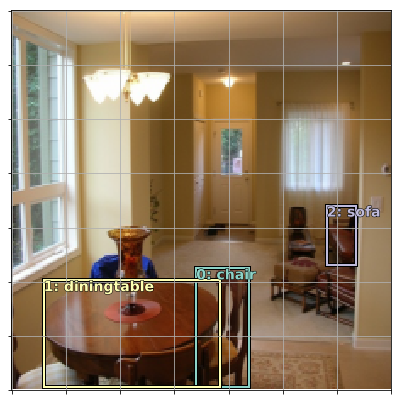

In [41]:
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, bbox, clas)

### This is anchor box

In [42]:
anc_grid = 4
k = 1

In [43]:
anc_offset = 1/(anc_grid*2)
anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)

anc_ctrs = np.tile(np.stack([anc_x,anc_y], axis=1), (k,1))
anc_sizes = np.array([[1/anc_grid,1/anc_grid] for i in range(anc_grid*anc_grid)])
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()

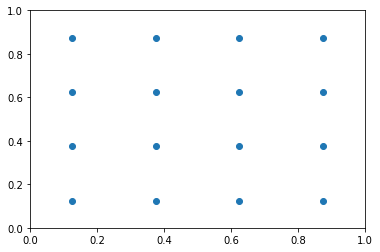

In [44]:
grid_sizes = V(np.array([1/anc_grid]), requires_grad=False).unsqueeze(1)
plt.scatter(anc_x, anc_y)
plt.xlim(0, 1)
plt.ylim(0, 1);

In [45]:
grid_sizes

Variable containing:
 0.2500
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]

In [46]:
anchors # center_x,center_y,width,height

Variable containing:
 0.1250  0.1250  0.2500  0.2500
 0.1250  0.3750  0.2500  0.2500
 0.1250  0.6250  0.2500  0.2500
 0.1250  0.8750  0.2500  0.2500
 0.3750  0.1250  0.2500  0.2500
 0.3750  0.3750  0.2500  0.2500
 0.3750  0.6250  0.2500  0.2500
 0.3750  0.8750  0.2500  0.2500
 0.6250  0.1250  0.2500  0.2500
 0.6250  0.3750  0.2500  0.2500
 0.6250  0.6250  0.2500  0.2500
 0.6250  0.8750  0.2500  0.2500
 0.8750  0.1250  0.2500  0.2500
 0.8750  0.3750  0.2500  0.2500
 0.8750  0.6250  0.2500  0.2500
 0.8750  0.8750  0.2500  0.2500
[torch.cuda.FloatTensor of size 16x4 (GPU 0)]

In [47]:
def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])
anchor_cnr # x1,y1 (lower left) ,x2,y2 (upper right)

Variable containing:
 0.0000  0.0000  0.2500  0.2500
 0.0000  0.2500  0.2500  0.5000
 0.0000  0.5000  0.2500  0.7500
 0.0000  0.7500  0.2500  1.0000
 0.2500  0.0000  0.5000  0.2500
 0.2500  0.2500  0.5000  0.5000
 0.2500  0.5000  0.5000  0.7500
 0.2500  0.7500  0.5000  1.0000
 0.5000  0.0000  0.7500  0.2500
 0.5000  0.2500  0.7500  0.5000
 0.5000  0.5000  0.7500  0.7500
 0.5000  0.7500  0.7500  1.0000
 0.7500  0.0000  1.0000  0.2500
 0.7500  0.2500  1.0000  0.5000
 0.7500  0.5000  1.0000  0.7500
 0.7500  0.7500  1.0000  1.0000
[torch.cuda.FloatTensor of size 16x4 (GPU 0)]

## Overlap b/t true bbox and anchor box

Goal: Each anchor box will be assigned to a ground-truth object, based on IOU of the object's bounding box and anchor box

In [48]:
overlaps = jaccard(bbox.data, anchor_cnr.data)
overlaps



Columns 0 to 9 
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0091
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0356  0.0549
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000

Columns 10 to 15 
 0.0922  0.0000  0.0000  0.0315  0.3985  0.0000
 0.0103  0.0000  0.2598  0.4538  0.0653  0.0000
 0.0000  0.1897  0.0000  0.0000  0.0000  0.0000
[torch.cuda.FloatTensor of size 3x16 (GPU 0)]

In [49]:
# for each anchor box, which object has largest IOU 
overlaps.max(0)

(
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0356
  0.0549
  0.0922
  0.1897
  0.2598
  0.4538
  0.3985
  0.0000
 [torch.cuda.FloatTensor of size 16 (GPU 0)], 
  0
  0
  0
  0
  0
  0
  0
  0
  1
  1
  0
  2
  1
  1
  0
  0
 [torch.cuda.LongTensor of size 16 (GPU 0)])

In [50]:
# for each obj, which anchorbox has largest IOU
overlaps.max(1)

(
  0.3985
  0.4538
  0.1897
 [torch.cuda.FloatTensor of size 3 (GPU 0)], 
  14
  13
  11
 [torch.cuda.LongTensor of size 3 (GPU 0)])

In [51]:
# Each anchor box will be assigned to a ground-truth object
# if that object has maximum IOU or its IOU > .5 on that anchor box 
# otherwise, assign 'background' as object

#first, set all max to a big value, 1.99
gt_overlap,gt_idx = map_to_ground_truth(overlaps) 
# get max IOU and its obj index for each anchor box


# get object from argmax index
# Note that gt_idx=0 is ambiguous: either clas[0]=8 or back ground
gt_clas = clas[gt_idx]; gt_clas

Variable containing:
  8
  8
  8
  8
  8
  8
  8
  8
 10
 10
  8
 17
 10
 10
  8
  8
[torch.cuda.LongTensor of size 16 (GPU 0)]

In [52]:
gt_overlap,gt_idx

(
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0356
  0.0549
  0.0922
  1.9900
  0.2598
  1.9900
  1.9900
  0.0000
 [torch.cuda.FloatTensor of size 16 (GPU 0)], 
  0
  0
  0
  0
  0
  0
  0
  0
  1
  1
  0
  2
  1
  1
  0
  0
 [torch.cuda.LongTensor of size 16 (GPU 0)])

In [53]:
# set threshold 0.5 for IOU and get obj label for each abox
thresh = 0.5
pos = gt_overlap > thresh

#torch.nonzero return tensor contain indices of nonzero input
pos_idx = torch.nonzero(pos)[:,0] # pos_idx: idx of anchor box where IOU > .5
neg_idx = torch.nonzero(1-pos)[:,0]

In [54]:
pos_idx


 11
 13
 14
[torch.cuda.LongTensor of size 3 (GPU 0)]

In [55]:
id2cat
# id2cat[20] is gonna be 'bg'

{0: 'aeroplane',
 1: 'bicycle',
 2: 'bird',
 3: 'boat',
 4: 'bottle',
 5: 'bus',
 6: 'car',
 7: 'cat',
 8: 'chair',
 9: 'cow',
 10: 'diningtable',
 11: 'dog',
 12: 'horse',
 13: 'motorbike',
 14: 'person',
 15: 'pottedplant',
 16: 'sheep',
 17: 'sofa',
 18: 'train',
 19: 'tvmonitor'}

In [56]:
gt_clas[neg_idx] = len(id2cat) # 20, aka bg
[id2cat[o] if o in id2cat else 'bg' for o in gt_clas.data]

['bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'sofa',
 'bg',
 'diningtable',
 'chair',
 'bg']

In [57]:
bbox[gt_idx] # get class's bbox for each anchor box
# that why you still ust gt_idx on ground-truth bbox 
# even thouh gt_idx is max-IOU class index

Variable containing:
 0.6786  0.4866  0.9911  0.6250
 0.6786  0.4866  0.9911  0.6250
 0.6786  0.4866  0.9911  0.6250
 0.6786  0.4866  0.9911  0.6250
 0.6786  0.4866  0.9911  0.6250
 0.6786  0.4866  0.9911  0.6250
 0.6786  0.4866  0.9911  0.6250
 0.6786  0.4866  0.9911  0.6250
 0.7098  0.0848  0.9911  0.5491
 0.7098  0.0848  0.9911  0.5491
 0.6786  0.4866  0.9911  0.6250
 0.5134  0.8304  0.6696  0.9063
 0.7098  0.0848  0.9911  0.5491
 0.7098  0.0848  0.9911  0.5491
 0.6786  0.4866  0.9911  0.6250
 0.6786  0.4866  0.9911  0.6250
[torch.cuda.FloatTensor of size 16x4 (GPU 0)]

In [58]:
# get max bbox coords for each anchor box
bbox[gt_idx][pos_idx]

Variable containing:
 0.5134  0.8304  0.6696  0.9063
 0.7098  0.0848  0.9911  0.5491
 0.6786  0.4866  0.9911  0.6250
[torch.cuda.FloatTensor of size 3x4 (GPU 0)]

In [59]:
gt_clas

Variable containing:
 20
 20
 20
 20
 20
 20
 20
 20
 20
 20
 20
 17
 20
 10
  8
 20
[torch.cuda.LongTensor of size 16 (GPU 0)]

In [60]:
anchors

Variable containing:
 0.1250  0.1250  0.2500  0.2500
 0.1250  0.3750  0.2500  0.2500
 0.1250  0.6250  0.2500  0.2500
 0.1250  0.8750  0.2500  0.2500
 0.3750  0.1250  0.2500  0.2500
 0.3750  0.3750  0.2500  0.2500
 0.3750  0.6250  0.2500  0.2500
 0.3750  0.8750  0.2500  0.2500
 0.6250  0.1250  0.2500  0.2500
 0.6250  0.3750  0.2500  0.2500
 0.6250  0.6250  0.2500  0.2500
 0.6250  0.8750  0.2500  0.2500
 0.8750  0.1250  0.2500  0.2500
 0.8750  0.3750  0.2500  0.2500
 0.8750  0.6250  0.2500  0.2500
 0.8750  0.8750  0.2500  0.2500
[torch.cuda.FloatTensor of size 16x4 (GPU 0)]

# Training (complete)

In [10]:
PATH = Path('data/pascal')
list(PATH.iterdir())

JPEGS = 'VOC2007/JPEGImages'
IMG_PATH = PATH/JPEGS

all_df = pd.read_csv(PATH / 'all_info.csv')
mult_cat= pd.read_csv(PATH / 'mult_cat.csv')
mult_bbox= pd.read_csv(PATH / 'mult_bbox.csv') 

[PosixPath('data/pascal/tmp'),
 PosixPath('data/pascal/all_info.csv'),
 PosixPath('data/pascal/VOC2012'),
 PosixPath('data/pascal/pascal_val2012.json'),
 PosixPath('data/pascal/pascal_test2007.json'),
 PosixPath('data/pascal/pascal_val2007.json'),
 PosixPath('data/pascal/lrg_bbox.csv'),
 PosixPath('data/pascal/VOC2007'),
 PosixPath('data/pascal/models'),
 PosixPath('data/pascal/mult_cat.csv'),
 PosixPath('data/pascal/mult_bbox.csv'),
 PosixPath('data/pascal/VOCtrainval_11-May-2012.tar'),
 PosixPath('data/pascal/pascal_train2012.json'),
 PosixPath('data/pascal/pascal_train2007.json'),
 PosixPath('data/pascal/lrg_cat.csv'),
 PosixPath('data/pascal/VOCtrainval_06-Nov-2007.tar')]

In [11]:
cats=all_df[['category_id','cat_name']].drop_duplicates().values

id2cat = {i[0]-1:i[1] for i in cats}
cat2id = {i[1]:i[0]-1 for i in cats}

mcs=np.array([np.array([cat2id[j] for j in i.split(' ')]) for i in mult_cat.cat_name.values ])
# mcs

val_idxs = get_cv_idxs(mult_bbox.shape[0])
((val_mcs,trn_mcs),) = split_by_idx(val_idxs, mcs)

In [12]:
k=1
# n_clas = len(id2cat)+1; n_clas
# n_act = k*(4+n_clas); n_act

21

25

In [13]:
f_model=resnet34
sz=224
bs=16

MBB_CSV = PATH / 'mult_bbox.csv'
aug_tfms = [RandomRotate(10, tfm_y=TfmType.COORD),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD),
            RandomFlip(tfm_y=TfmType.COORD)]
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=aug_tfms)
md = ImageClassifierData.from_csv(PATH, JPEGS, MBB_CSV, tfms=tfms, continuous=True, num_workers=4)


In [14]:
# md.trn_ds (created from ImageClassifierData.from_csv) and trn_mcs (from get_cv_idxs) have same indices
# as .from_csv also used get_cv_idxs func
trn_ds2 = ConcatLblDataset(md.trn_ds, trn_mcs)
val_ds2 = ConcatLblDataset(md.val_ds, val_mcs)
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

In [15]:
head_reg4 = SSD_Head(k, -3.)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

In [16]:
loss_f = BCE_Loss(len(id2cat))

## Anchor box

In [17]:
anc_grid = 4
k = 1

anc_offset = 1/(anc_grid*2)
anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)

anc_ctrs = np.tile(np.stack([anc_x,anc_y], axis=1), (k,1))
anc_sizes = np.array([[1/anc_grid,1/anc_grid] for i in range(anc_grid*anc_grid)])
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()

In [21]:
grid_sizes = V(np.array([1/anc_grid]), requires_grad=False).unsqueeze(1)

In [18]:
def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])
anchor_cnr # x1,y1 (lower left) ,x2,y2 (upper right)

Variable containing:
 0.0000  0.0000  0.2500  0.2500
 0.0000  0.2500  0.2500  0.5000
 0.0000  0.5000  0.2500  0.7500
 0.0000  0.7500  0.2500  1.0000
 0.2500  0.0000  0.5000  0.2500
 0.2500  0.2500  0.5000  0.5000
 0.2500  0.5000  0.5000  0.7500
 0.2500  0.7500  0.5000  1.0000
 0.5000  0.0000  0.7500  0.2500
 0.5000  0.2500  0.7500  0.5000
 0.5000  0.5000  0.7500  0.7500
 0.5000  0.7500  0.7500  1.0000
 0.7500  0.0000  1.0000  0.2500
 0.7500  0.2500  1.0000  0.5000
 0.7500  0.5000  1.0000  0.7500
 0.7500  0.7500  1.0000  1.0000
[torch.cuda.FloatTensor of size 16x4 (GPU 0)]

In [ ]:
learn.crit = ssd_loss
lr = 1e-2
lrs = np.array([lr/100,lr/10,lr])

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      94.262919  57908.78125



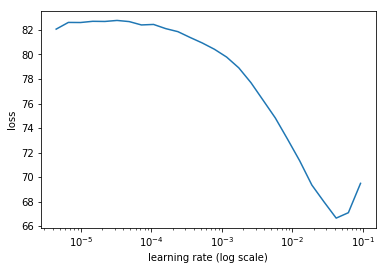

In [22]:
learn.lr_find(lrs/1000,1.)
learn.sched.plot(1)

In [23]:
learn.fit(lr, 1, cycle_len=5, use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      43.683602  32.115784 
    1      34.719116  29.178749                           
    2      30.617647  27.338123                           
    3      28.022192  26.330753                           
    4      26.059685  25.788784                           



[25.788784]

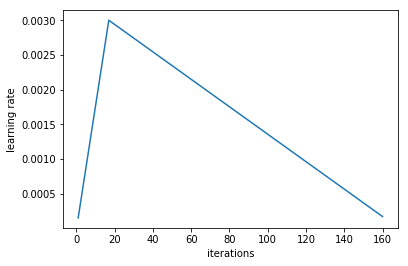

In [24]:
learn.sched.plot_lr()

In [ ]:
# learn.save('0')
# learn.load('0')

# Testing

In [25]:
x,y = next(iter(md.val_dl))
x,y = V(x),V(y)
learn.model.eval()
batch = learn.model(x) #model forward pass
b_clas,b_bb = batch

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d

In [26]:
# predicted class and coord from 2 conv2d layers
b_clas.size(),b_bb.size()

(torch.Size([64, 16, 21]), torch.Size([64, 16, 4]))

In [27]:
idx=7
b_clasi = b_clas[idx]
b_bboxi = b_bb[idx]
ima=md.val_ds.ds.denorm(to_np(x))[idx]
bbox,clas = get_y(y[0][idx], y[1][idx])

In [28]:
def torch_gt(ax, ima, bbox, clas, prs=None, thresh=0.4):
    return show_ground_truth(ax, ima, to_np((bbox*224).long()),
         to_np(clas), to_np(prs) if prs is not None else None, thresh)

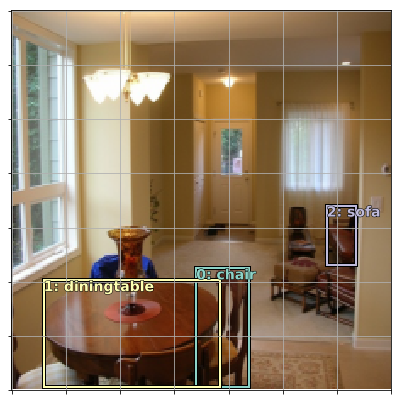

In [29]:
# ground-truth
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, bbox, clas)

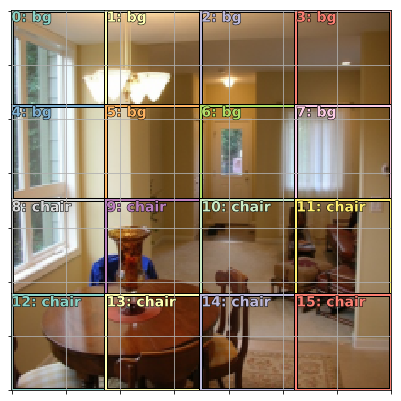

In [30]:
# obj prediction for each abox
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, anchor_cnr, b_clasi.max(1)[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


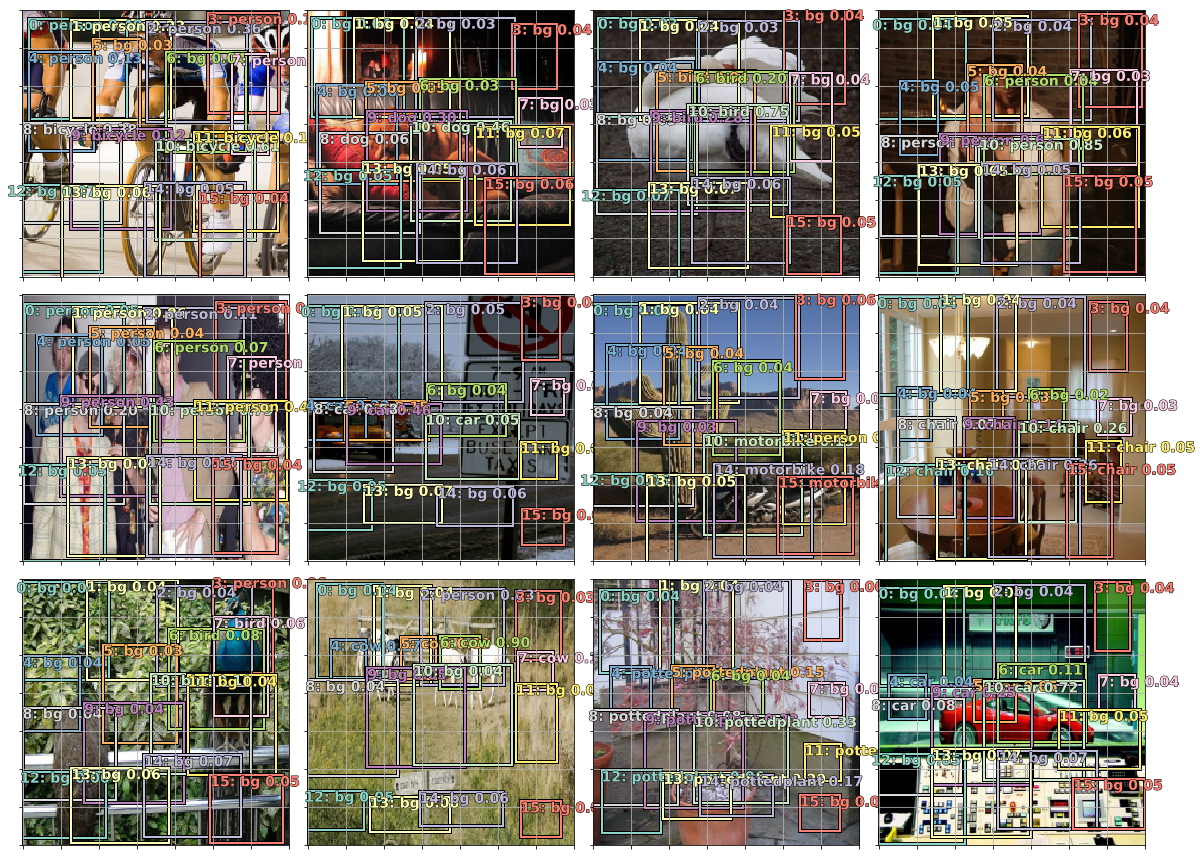

In [34]:

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for idx,ax in enumerate(axes.flat):
    ima=md.val_ds.ds.denorm(to_np(x))[idx]
    bbox,clas = get_y(y[0][idx], y[1][idx])
#     bbox,clas = get_y(bbox,clas); 
#     bbox,clas
    a_ic = actn_to_bb(b_bb[idx], anchors)
    torch_gt(ax, ima, a_ic, b_clas[idx].max(1)[1], b_clas[idx].max(1)[0].sigmoid(), 0.01)
plt.tight_layout()

In [37]:
b_clas[0].max(1)

(Variable containing:
 -0.4244
 -1.2144
 -0.5879
 -1.7251
 -1.9428
 -3.3429
 -3.3019
 -3.0204
 -0.5067
 -1.9753
  0.4381
 -1.6866
 -2.6390
 -2.7187
 -2.9926
 -3.1540
 [torch.cuda.FloatTensor of size 16 (GPU 0)], Variable containing:
  14
  14
  14
  14
  14
  20
  20
  14
   1
   1
   1
   1
  20
  20
  20
  20
 [torch.cuda.LongTensor of size 16 (GPU 0)])

In [39]:
b_clas[0].max(1)[0].sigmoid()

Variable containing:
 0.3955
 0.2289
 0.3571
 0.1512
 0.1253
 0.0341
 0.0355
 0.0465
 0.3760
 0.1218
 0.6078
 0.1562
 0.0667
 0.0619
 0.0478
 0.0409
[torch.cuda.FloatTensor of size 16 (GPU 0)]

In [35]:
a_ic

Variable containing:
 0.0349  0.0013  0.4023  0.3224
 0.0305  0.2498  0.4011  0.5205
 0.0265  0.4375  0.4006  0.7803
 0.0128  0.8159  0.2722  0.9505
 0.3640  0.0445  0.5285  0.1795
 0.3803  0.3584  0.5365  0.5185
 0.3206  0.4537  0.6144  0.7857
 0.3622  0.8339  0.4997  0.9669
 0.4521 -0.0298  0.8157  0.3249
 0.4037  0.2026  0.7730  0.5769
 0.3842  0.3988  0.7556  0.7737
 0.4921  0.6789  0.7163  0.9861
 0.6577 -0.0287  1.0000  0.3271
 0.6414  0.2010  0.9694  0.5721
 0.6507  0.4522  0.9385  0.8250
 0.7520  0.7357  0.9377  1.0023
[torch.cuda.FloatTensor of size 16x4 (GPU 0)]